# Markov Chain and Transition Matrix of TSLA

## Package Imports

In [91]:
from datetime import datetime
import pandas as pd
import numpy as np
import pydtmc
import yfinance as yf
import matplotlib.pyplot as plt
# inline matplotlib
%matplotlib inline

## Data

Retrieve the 10-year historical data for the TESLA stock by utilizing the Yahoo Finance API.

In [94]:
# define ticker
ticker = "TSLA"
# Fetch 10 yesrs of data
data_raw = yf.download(ticker, period='10y', interval='1d')

[*********************100%***********************]  1 of 1 completed


Next, we compute the daily returns of the adjusted closing price for TESLA stock.

In [143]:
# filter Adj Close column and compute daily return
data = data_raw[["Adj Close"]].copy()
data.loc[:, "Return"] = data["Adj Close"].pct_change()
data = data[1:]

## Markov Chain

### 10 Year Markov Chain

We define three distinct states for the daily returns: Bear (negative returns), Consolidation (minimal or no change), and Bull (positive returns).

Subsequently, we create a new 'priorState' column to represent the previous day's state. We then calculate the transition matrix using the 'crosstab' function in pandas, which shows the frequency of state transitions

In [144]:
# define 3 states for the `Return` column: Bull, Bear and Cons based on `Return` column
data.loc[:, "State"] = pd.cut(
    data["Return"],
    bins=[-np.inf, -0.001, 0.001, np.inf],
    labels=["Bear", "Cons", "Bull"],
)
# add `priorState` column
data.loc[:, "priorState"] = data["State"].shift(1)
# drop nan values
data = data.dropna()
# define transition_matrix based on `State` and `priorState` columns
transition_matrix = pd.crosstab(data["priorState"], data["State"], normalize="index")

Presented here is the transition matrix for daily states over the past ten years.

Upon observation, it appears that the 'priorState' does not significantly influence the current state as the column values show remarkable similarity. To illustrate, irrespective of what the prior state was, the probability that the current state will be 'Bear' is approximately 44.7 percent

In [145]:
transition_matrix

State,Bear,Cons,Bull
priorState,,,
Bear,0.447120,0.030095,0.522786
Cons,0.448718,0.025641,0.525641
Bull,0.477237,0.032182,0.490581


We create a MarkovChain object using the pydtmc package and analyze the attributes of the resulting Markov chain:

1. The model does not have any absorbing states, meaning there is no state that, once entered, cannot be left. In other words, no diagonal element has a value of 1.
2. The chain is ergodic, which indicates that it is both irreducible and aperiodic.
3. All three states (Bear, Consolidation, and Bull) are recurrent, meaning that there is still a chance to be in any of these states even after an infinite amount of time.
4. There are no transient states; all states are recurrent.
5. The steady-state probabilities show that the likelihood of ending up in the Bull or Bear state after an infinite time is significantly higher than ending up in the Consolidation state

In [146]:
# create a markov chain based on states_matrix
mc = pydtmc.MarkovChain(transition_matrix.values, transition_matrix.index.tolist())
# print mc attributes
print("model absorbing states:", mc.absorbing_states)
print("is model ergodic?", mc.is_ergodic)
print("model recurrent states:", mc.recurrent_states)
print("model transient states:", mc.transient_states)
print("model steady state:", mc.steady_states)

model absorbing states: []
is model ergodic? True
model recurrent states: ['Bear', 'Cons', 'Bull']
model transient states: []
model steady state: [array([0.46242545, 0.03101392, 0.50656064])]


We will now create a visual representation of the transition matrix by plotting the corresponding graph, which will help us better understand the state transitions and their probabilities

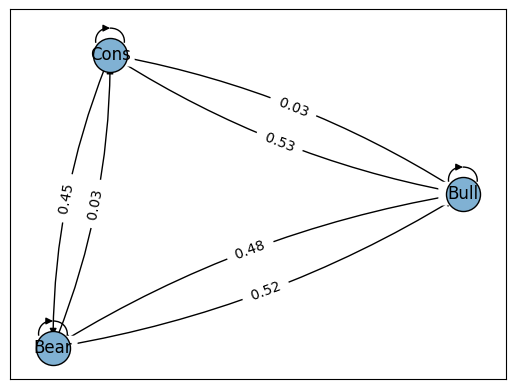

In [147]:
# plot the transition graph
pydtmc.plot_graph(mc)

The eigenvalues plot reveals that one of the eigenvalues is approximately 1, while the others are close to 0. This suggests that, in the long run, our Markov chain will converge to a steady state.

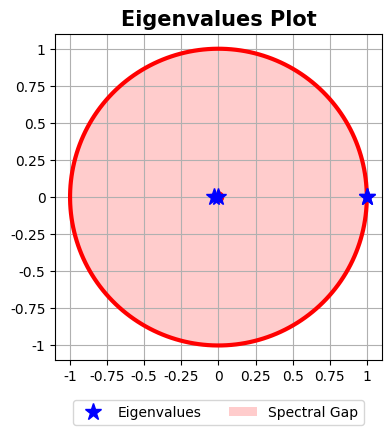

In [148]:
# plot eigenvalues
pydtmc.plot_eigenvalues(mc)

The sequence plot further illustrates the steady-state behavior of the Markov chain, providing additional evidence of its convergence over time.

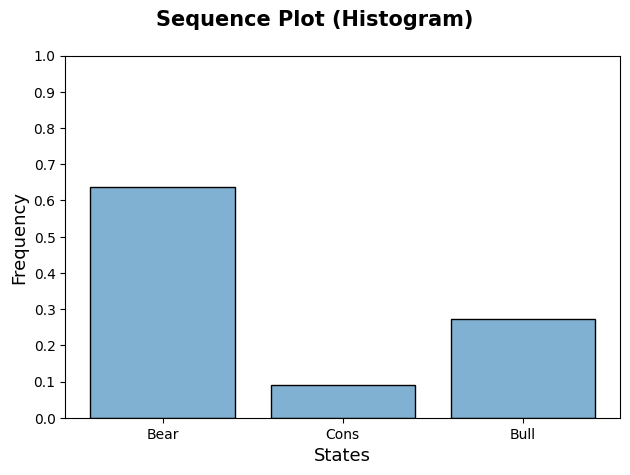

In [149]:
# plot sequences in histogram
pydtmc.plot_sequence(mc, 10, plot_type="histogram")

Additionally, we will visualize the transition matrix as a heatmap, which offers an intuitive way to examine the state transition probabilities and their relative magnitudes.

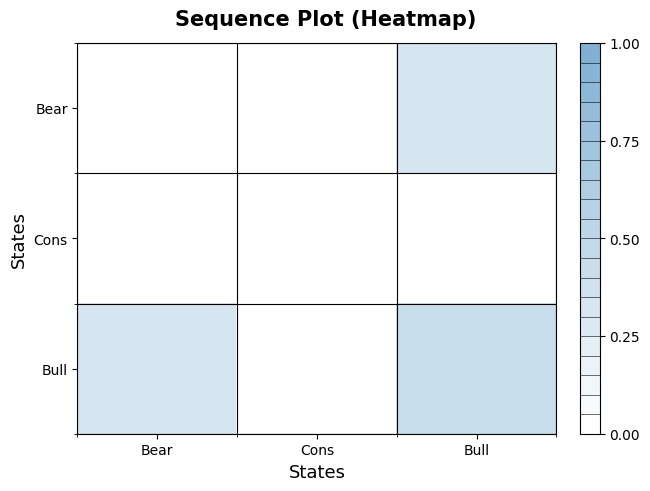

In [150]:
# plot sequences in heatmap
pydtmc.plot_sequence(mc, 10, plot_type="heatmap")

The matrix plot displays the probabilistic behavior of our Markov chain at each step, providing a comprehensive view of how the transition probabilities evolve over time.

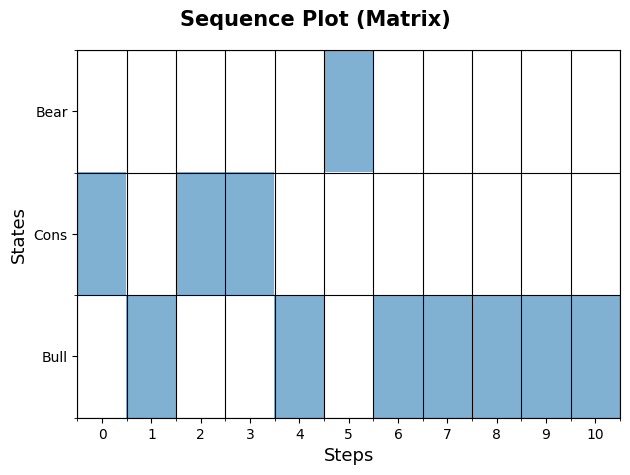

In [106]:
# plot sequqnces in matrix
pydtmc.plot_sequence(mc, 10, plot_type="matrix")

We will also create a redistribution plot for the Markov chain. This plot illustrates the probabilities of being in a specific state at each step, given that we start from any initial state. It offers valuable insights into the distribution of states over time.

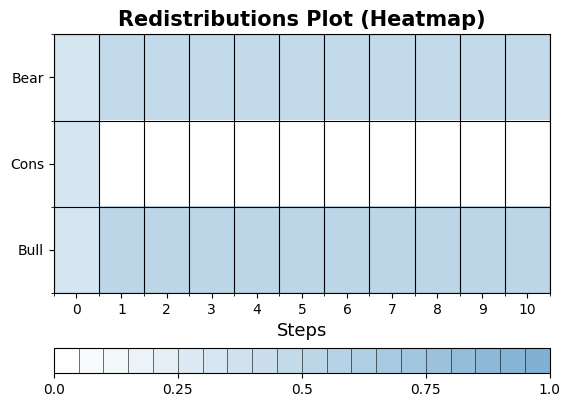

In [151]:
# plot redistribution in heatmap
pydtmc.plot_redistributions(mc, 10, plot_type="heatmap")

Next, we will create a similar visualization using a 'projection' plot type. This alternative representation will further help us understand how the probabilities of being in a specific state evolve over time, starting from any initial state.

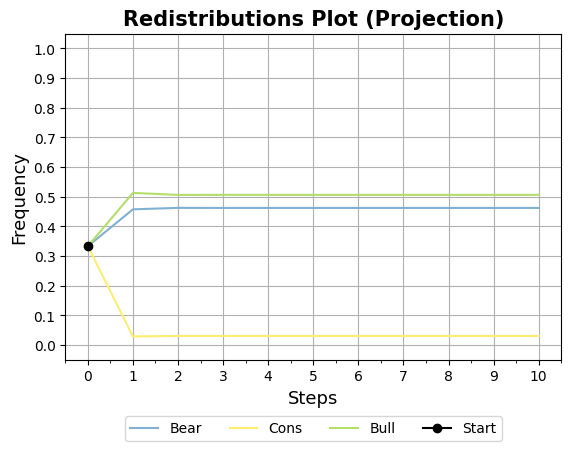

In [152]:
# plot redistributions in projection
pydtmc.plot_redistributions(mc, 10, plot_type="projection")

### 1 Year Transition Matrix

In this section, we calculate the annual transition matrix for the ten-year period between May 15, 2013, and today. The result will be a 3x3x10 matrix, representing the transition probabilities for each year in the period.

In [153]:
# create a 3x3x10 matrix of zeros
state_matrix_annual = np.zeros((3, 3, 10))
# compute states matrix for each year
start_date = data.index.min()
for i in range(10):
    # filter data for each year
    data_year = data.loc[start_date + pd.Timedelta(days=i*365): start_date + pd.Timedelta(days=(i+1)*365)]
    # compute states matrix for each year
    states_matrix = pd.crosstab(data_year["priorState"], data_year["State"], normalize="index")
    # add states matrix to zeros
    state_matrix_annual[:, :, i] = states_matrix.values 

We can retrieve all the values of each transition in the ten-year period using NumPy indexing, as shown below.

In [121]:
state_matrix_annual[0, 0, :] # Bear -> Bear
state_matrix_annual[0, 1, :] # Bear -> Cons
state_matrix_annual[0, 2, :] # Bear -> Bull
state_matrix_annual[1, 0, :] # Cons -> Bear
state_matrix_annual[1, 1, :] # Cons -> Cons
state_matrix_annual[1, 2, :] # Cons -> Bull
state_matrix_annual[2, 0, :] # Bull -> Bear
state_matrix_annual[2, 1, :] # Bull -> Cons
state_matrix_annual[2, 2, :]; # Bull -> Bull

We can plot the probabilities of each transition over the ten-year period, which illustrates that these probabilities are not constant over time.

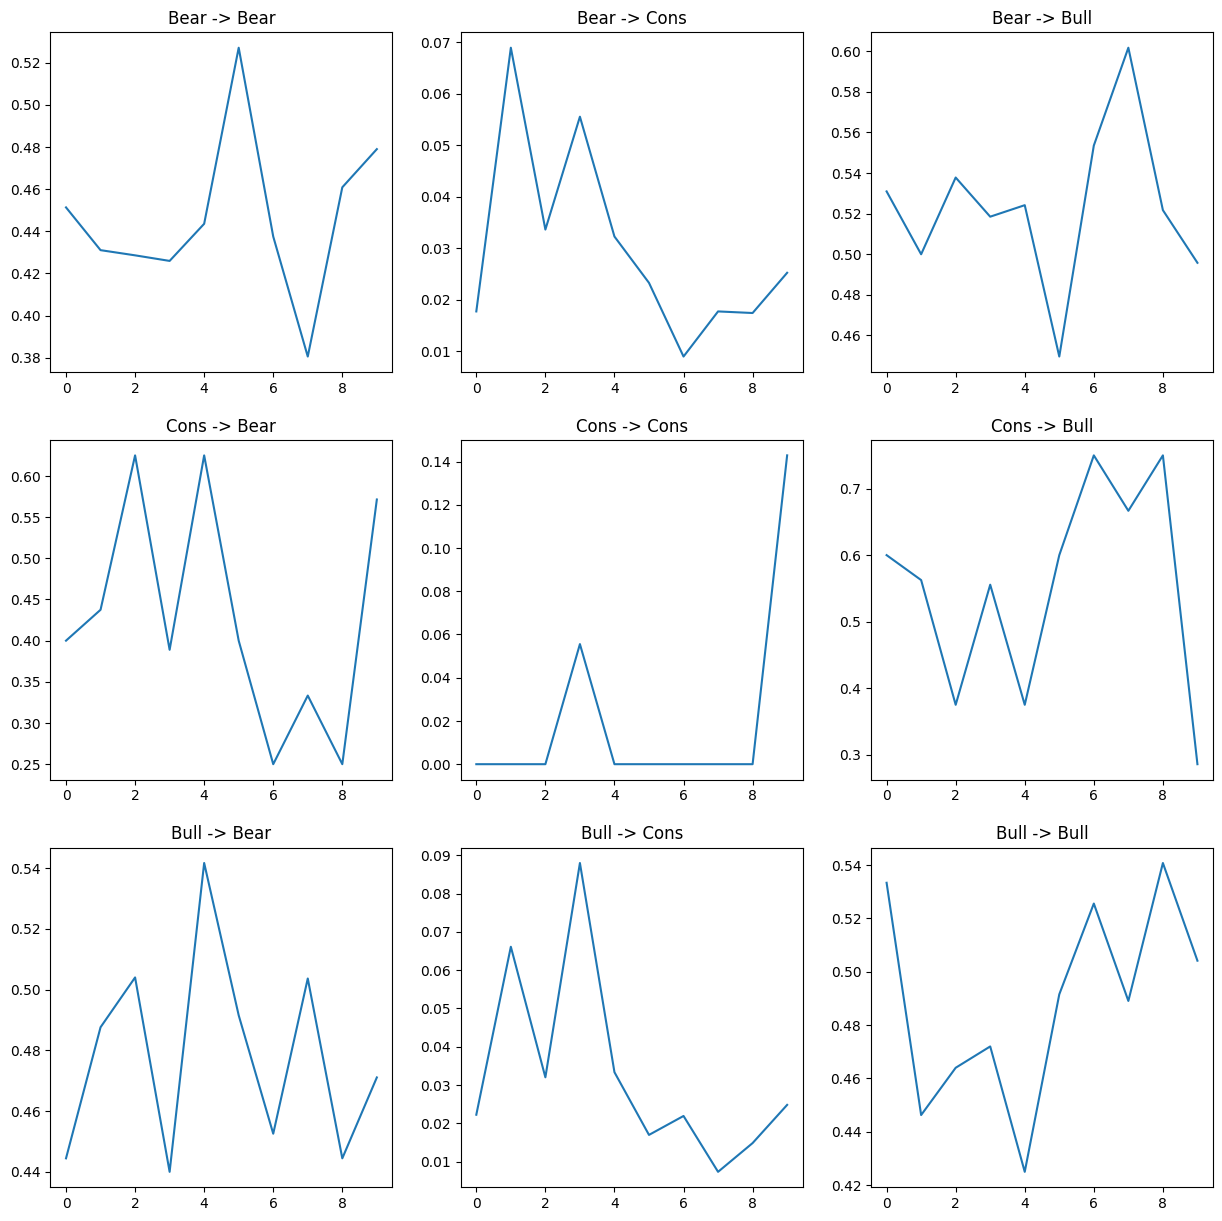

In [122]:
# 3x3 plot
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

import itertools
for i, j in itertools.product(range(3), range(3)):
    axs[i, j].plot(state_matrix_annual[i, j, :])
    axs[i, j].set_title(f"{mc.states[i]} -> {mc.states[j]}")

### Steady State behaviour of the last year's Transition Matrix

In [124]:
# `data_year` stores the data of the last year from the previous for loop.
data_last = data_year.copy()

There are three methods to obtain the steady-state probabilities of each state:

1. Using the steady-state formula.
2. Using the 'pydtmc' package.
3. Taking the nth power of the transition matrix.

All three methods yield the same result. Additionally, we can plot the probabilities of each state over the ten-year period, demonstrating that these probabilities vary over time.

#### 1. Formula

The steady-state probabilities represent the long-term behavior of the Markov process, where the state probabilities converge to a constant vector regardless of the initial state. We can obtain the steady-state probabilities by solving the linear system:
$$
\pi P = \pi
$$
Here, π is a row vector of steady-state probabilities, and P is the transition probability matrix.

In [134]:
transition_matrix = pd.crosstab(data_last["priorState"], data_last["State"], normalize="index")
# Define the transition probability
P = np.array(transition_matrix)
# Subtract the identity matrix from the transpose of the transition probability matrix, and append a row of ones to create the linear system
A = np.vstack((P.T - np.eye(3), np.ones(3)))
# Create the target vector b with zeros and a one at the end
b = np.array([0, 0, 0, 1])
# Solve the linear system using NumPy's lstsq function
x = np.linalg.lstsq(A, b, rcond=None)[0]

# print the steady state
print('Bear\tCons\tBull')
print(np.round(x, 4))

Bear	Cons	Bull
[0.4777 0.0283 0.494 ]


#### 2. Using pydtmc package

In [136]:
mc = pydtmc.MarkovChain(transition_matrix.values, transition_matrix.index.tolist())
x = mc.steady_states
# print the steady state
print('Bear\tCons\tBull')
print(np.round(x, 4))

Bear	Cons	Bull
[[0.4777 0.0283 0.494 ]]


#### 3. nth power of transition matrix

In [141]:
# matmult states_matrix 50 times to itself
states_matrix_n = np.linalg.matrix_power(states_matrix, 50)
states_matrix_n

array([[0.47770029, 0.02833815, 0.49396156],
       [0.47770029, 0.02833815, 0.49396156],
       [0.47770029, 0.02833815, 0.49396156]])

In conclusion, regardless of the starting state, our Markov chain has approximately the same probability of ending up in the 'Bear' or 'Bull' state, while the likelihood of ending up in the 'Consolidation' state in the long term is considerably lower.